In [19]:
import os
import pandas as pd
from zipfile import ZipFile

import numpy as np
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt

In [20]:
# Unzip the archive (if not done yet)
unzipped_file_path = os.path.join("..", "data", "app5-data", "unzipped_data")
if (not os.path.exists(unzipped_file_path)) or (not os.path.isdir(unzipped_file_path)):
    os.makedirs(unzipped_file_path, exist_ok=True)
    zipped_file_path = os.path.join("..", "data", "app5-data", "compressed.zip")
    # Unzip the archive
    with ZipFile(zipped_file_path, 'r') as zip_ref:
        zip_ref.extractall(unzipped_file_path)

In [25]:
# Base directory after extraction
base_dir = os.path.join(unzipped_file_path, "Data")

# Data collection
data_list = []

# Walk through 'Train' and 'Test'
for set_type in ['Train', 'Test']:
    for stage in ['awake', 'nonrem', 'rem']:
        folder_path = os.path.join(base_dir, set_type, stage)
        for filename in os.listdir(folder_path):
            if filename.endswith(".csv"):
                file_path = os.path.join(folder_path, filename)
                df = pd.read_csv(file_path)
                df['stage'] = stage
                df['set'] = set_type
                df['file'] = filename  # Optional: keep track of the file source
                data_list.append(df)

# Combine all into one DataFrame
full_df = pd.concat(data_list, ignore_index=True)
full_df = full_df.drop(columns=["emg"])
full_df = full_df.dropna(subset=['eog'])
# Show a preview
print(full_df.head())

    eog  stage    set           file
0  39.0  awake  Train  0_subj_10.csv
1  36.0  awake  Train  0_subj_10.csv
2  36.0  awake  Train  0_subj_10.csv
3  40.0  awake  Train  0_subj_10.csv
4  46.0  awake  Train  0_subj_10.csv


In [26]:
def bandpass_filter(data, lowcut=0.5, highcut=15.0, fs=200, order=4):
    nyq = 0.5 * fs
    b, a = butter(order, [lowcut/nyq, highcut/nyq], btype='band')
    padlen = min(3 * (len(b)-1), len(data)-1)
    return filtfilt(b, a, data, padlen=padlen)

# Process each file (each file is a separate signal)
filtered_list = []
for file, group in full_df.groupby('file'):
    group = group.copy()
    group['eog'] = bandpass_filter(group['eog'].values)
    filtered_list.append(group)

full_df = pd.concat(filtered_list, ignore_index=True)
print(full_df.head())

        eog   stage    set          file
0  0.868383  nonrem  Train  0_subj_1.csv
1  2.599143  nonrem  Train  0_subj_1.csv
2  4.096697  nonrem  Train  0_subj_1.csv
3  5.168638  nonrem  Train  0_subj_1.csv
4  5.685183  nonrem  Train  0_subj_1.csv


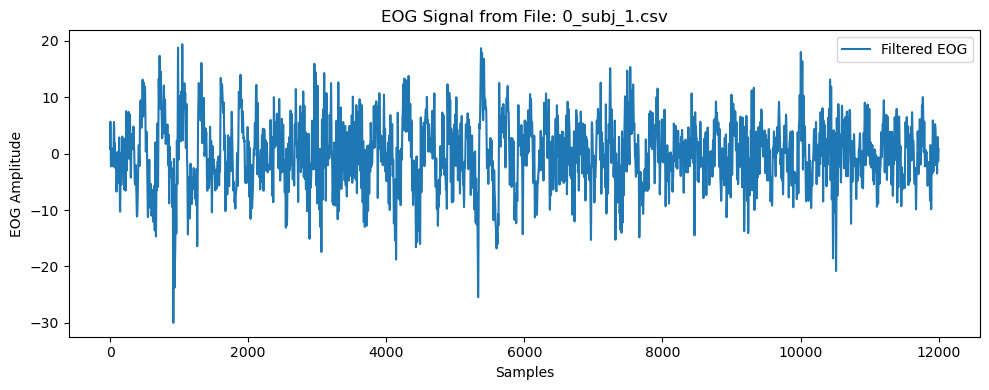

In [27]:
# Choose one file (using the first unique file as an example)
file_id = full_df['file'].unique()[0]
file_data = full_df[full_df['file'] == file_id]

plt.figure(figsize=(10, 4))
plt.plot(file_data.index, file_data['eog'], label='Filtered EOG')
plt.title(f'EOG Signal from File: {file_id}')
plt.xlabel('Samples')
plt.ylabel('EOG Amplitude')
plt.legend()
plt.tight_layout()
plt.show()

In [28]:
from scipy.stats import kurtosis, skew
from scipy.signal import welch
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

def extract_features(signal, fs=200):
    # Time-domain features
    feat = {
        'mean': np.mean(signal),
        'std': np.std(signal),
        'min': np.min(signal),
        'max': np.max(signal),
        'median': np.median(signal),
        'energy': np.sum(signal ** 2),
        'kurtosis': kurtosis(signal),
        'skewness': skew(signal)
    }

    # Frequency-domain features using Welch's method
    freqs, psd = welch(signal, fs, nperseg=min(256, len(signal)))
    psd_norm = psd / (np.sum(psd) + 1e-10)  # Normalize PSD to sum to 1
    dominant_idx = np.argmax(psd)
    feat['dominant_frequency'] = freqs[dominant_idx]
    feat['spectral_entropy'] = -np.sum(psd_norm * np.log2(psd_norm + 1e-10))
    feat['spectral_bandwidth'] = np.sqrt(np.sum(((freqs - freqs[dominant_idx])**2) * psd_norm))

    return feat

In [29]:
# Extract features per file from your full_df (which contains columns 'file', 'stage', and cleaned 'eog')
features = []
labels = []

for file_id, group in full_df.groupby('file'):
    # All rows in a file share the same label
    label = group['stage'].iloc[0]
    signal = group['eog'].values
    feat = extract_features(signal, fs=200)
    features.append(feat)
    labels.append(label)

features_df = pd.DataFrame(features)

In [30]:
# Encode labels and split the data
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)
X_train, X_test, y_train, y_test = train_test_split(features_df, labels_encoded, test_size=0.3, random_state=42)


In [31]:
# Train a Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [32]:
# Evaluate on the test set
predictions = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions, target_names=le.classes_))

Accuracy: 0.7350427350427351
              precision    recall  f1-score   support

       awake       0.84      0.78      0.81        99
      nonrem       0.62      0.79      0.70        73
         rem       0.76      0.60      0.67        62

    accuracy                           0.74       234
   macro avg       0.74      0.72      0.72       234
weighted avg       0.75      0.74      0.74       234

